In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/clean_long_petrol_prices.csv")
df["date"] = pd.to_datetime(df["date"])

df.head()


,date,State,Price,MonthlyChange,PctChange,MA_3,MA_6
0,2017-05-01,Haryana,67.84,NaN,NaN,NaN,NaN
1,2017-06-01,Haryana,66.70,-1.14,-1.680425,NaN,NaN
2,2017-07-01,Haryana,62.68,-4.02,-6.026987,65.740000,NaN
3,2017-08-01,Haryana,64.98,2.30,3.669432,64.786667,NaN
4,2017-09-01,Haryana,68.82,3.84,5.909511,65.493333,NaN


In [2]:
wide = df.pivot(index="date", columns="State", values="Price")
wide = wide.sort_index()
wide.head()


State,Haryana,Uttar Pradesh,Assam,Bihar,Delhi,Gujarat,Karnataka,Kerala,Madhya Pradesh,Maharashtra,Punjab,Rajasthan,Tamil Nadu,Telangana,West_bengal
date,,,,,,,,,,,,,,,
2017-05-01,67.84,70.74,71.41,71.16,68.09,71.15,73.01,72.43,75.87,77.46,73.41,71.12,71.17,72.68,70.68
2017-06-01,66.70,69.86,70.52,69.85,66.91,68.91,71.59,71.27,74.65,78.44,72.51,69.88,69.93,71.49,69.52
2017-07-01,62.68,66.53,65.83,65.93,63.09,64.77,64.24,66.93,69.62,74.30,67.93,65.77,65.46,67.02,66.14
2017-08-01,64.98,68.63,68.03,69.78,65.40,67.09,66.39,69.06,71.99,74.56,70.32,67.93,67.71,69.24,68.56
2017-09-01,68.82,71.61,71.17,73.61,69.26,71.05,70.34,73.07,75.63,78.38,74.25,71.88,71.78,73.34,72.02


In [4]:
def split_series(series, test_months=12):
    train = series.iloc[:-test_months]
    test = series.iloc[-test_months:]
    return train, test


In [5]:
results = []

for state in wide.columns:
    series = wide[state].dropna()
    train, test = split_series(series)

    # Naive: forecast = last train value repeated
    naive_pred = pd.Series([train.iloc[-1]] * len(test), index=test.index)

    # Rolling avg: use last 3-month mean from train, repeated
    rolling_pred = pd.Series([train.tail(3).mean()] * len(test), index=test.index)

    # Error metrics
    naive_rmse = np.sqrt(((test - naive_pred) ** 2).mean())
    rolling_rmse = np.sqrt(((test - rolling_pred) ** 2).mean())

    results.append([state, naive_rmse, rolling_rmse])

metrics = pd.DataFrame(results, columns=["State", "Naive_RMSE", "Rolling3_RMSE"])
metrics.sort_values("Rolling3_RMSE")


,State,Naive_RMSE,Rolling3_RMSE
12,Tamil Nadu,5.286099,3.849083
7,Kerala,6.422106,4.698850
13,Telangana,6.682443,4.913075
3,Bihar,8.196496,4.923167
14,West_bengal,6.667999,5.020141
5,Gujarat,10.062756,5.363989
0,Haryana,10.091275,5.588700
9,Maharashtra,8.344087,5.624907
1,Uttar Pradesh,10.518865,5.848900
11,Rajasthan,10.516074,6.340680


In [9]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ses_results = []

for state in wide.columns:
    series = wide[state].dropna()
    train, test = split_series(series)

    model = SimpleExpSmoothing(train).fit()
    ses_pred = model.forecast(len(test))

    ses_rmse = np.sqrt(((test - ses_pred) ** 2).mean())
    ses_results.append([state, ses_rmse])

ses_metrics = pd.DataFrame(ses_results, columns=["State", "SES_RMSE"])
ses_metrics.sort_values("SES_RMSE")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

,State,SES_RMSE
12,Tamil Nadu,5.406021
7,Kerala,6.577591
13,Telangana,6.848815
14,West_bengal,6.852818
9,Maharashtra,8.262892
3,Bihar,8.353695
5,Gujarat,10.077421
0,Haryana,10.169249
1,Uttar Pradesh,10.561321
11,Rajasthan,10.673220


In [10]:
future_forecasts = {}

for state in wide.columns:
    series = wide[state].dropna()
    model = SimpleExpSmoothing(series).fit()
    future = model.forecast(12)
    future_forecasts[state] = future

future_df = pd.DataFrame(future_forecasts)
future_df.index = pd.date_range(start=wide.index[-1] + pd.offsets.MonthBegin(),
                                periods=12, freq="MS")
future_df.head()


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

,Haryana,Uttar Pradesh,Assam,Bihar,Delhi,Gujarat,Karnataka,Kerala,Madhya Pradesh,Maharashtra,Punjab,Rajasthan,Tamil Nadu,Telangana,West_bengal
2023-01-01,97.426401,96.566594,95.965502,107.216963,96.717929,96.629878,101.890069,107.695319,108.603665,106.354085,96.173609,108.434391,102.62706,109.643511,105.994624
2023-02-01,97.426401,96.566594,95.965502,107.216963,96.717929,96.629878,101.890069,107.695319,108.603665,106.354085,96.173609,108.434391,102.62706,109.643511,105.994624
2023-03-01,97.426401,96.566594,95.965502,107.216963,96.717929,96.629878,101.890069,107.695319,108.603665,106.354085,96.173609,108.434391,102.62706,109.643511,105.994624
2023-04-01,97.426401,96.566594,95.965502,107.216963,96.717929,96.629878,101.890069,107.695319,108.603665,106.354085,96.173609,108.434391,102.62706,109.643511,105.994624
2023-05-01,97.426401,96.566594,95.965502,107.216963,96.717929,96.629878,101.890069,107.695319,108.603665,106.354085,96.173609,108.434391,102.62706,109.643511,105.994624


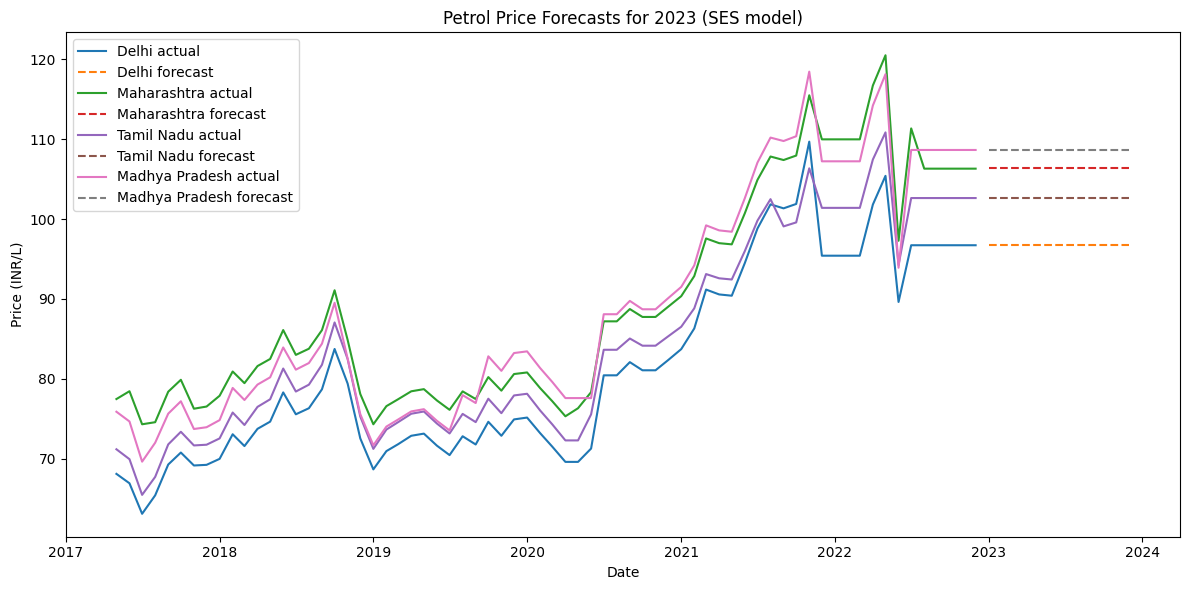

In [11]:
states_to_plot = ["Delhi", "Maharashtra", "Tamil Nadu", "Madhya Pradesh"]

plt.figure(figsize=(12,6))

for st in states_to_plot:
    plt.plot(wide[st], label=f"{st} actual")
    plt.plot(future_df[st], linestyle="dashed", label=f"{st} forecast")

plt.title("Petrol Price Forecasts for 2023 (SES model)")
plt.xlabel("Date")
plt.ylabel("Price (INR/L)")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
future_df.to_csv("../data/petrol_price_forecasts_2023.csv")
print("Saved to data/petrol_price_forecasts_2023.csv")


Saved to data/petrol_price_forecasts_2023.csv


started forecasting with two simple baselines: a naive model (prices stay at the last observed value) and a 3-month rolling average. Both provide a clear benchmark for predictability across states.

then applied SES, method that weights recent months more heavily. This improved accuracy for most states, especially those with smoother trends.

SES produced mostly flat forecasts because it models only the current price level and not the trend, so late-2022 stability affected the modeling. To capture gradual upward or downward movement while staying interpretable, I'm using Holt’s linear trend method next ( a very big thank you to my cs teacher, Jasmine Ma'am, who explained its working to me), which adds trend.

In [13]:
from statsmodels.tsa.holtwinters import Holt


In [14]:
holt_results = []

for state in wide.columns:
    series = wide[state].dropna()
    train, test = split_series(series)

    model = Holt(train).fit()
    holt_pred = model.forecast(len(test))

    holt_rmse = np.sqrt(((test - holt_pred) ** 2).mean())
    holt_results.append([state, holt_rmse])

holt_metrics = pd.DataFrame(holt_results, columns=["State", "Holt_RMSE"])
holt_metrics.sort_values("Holt_RMSE")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

,State,Holt_RMSE
12,Tamil Nadu,13.699786
9,Maharashtra,13.914454
7,Kerala,18.739896
14,West_bengal,18.828866
13,Telangana,19.098626
2,Assam,19.677037
1,Uttar Pradesh,22.390775
3,Bihar,22.604605
0,Haryana,22.740666
8,Madhya Pradesh,23.661177


In [15]:
future_forecasts = {}

for state in wide.columns:
    series = wide[state].dropna()
    model = Holt(series).fit()
    future_forecasts[state] = model.forecast(12)

future_df = pd.DataFrame(future_forecasts)
future_df.index = pd.date_range(
    start=wide.index[-1] + pd.offsets.MonthBegin(),
    periods=12,
    freq="MS"
)

future_df.head()


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

,Haryana,Uttar Pradesh,Assam,Bihar,Delhi,Gujarat,Karnataka,Kerala,Madhya Pradesh,Maharashtra,Punjab,Rajasthan,Tamil Nadu,Telangana,West_bengal
2023-01-01,97.968215,97.035501,96.497960,108.042217,97.131014,96.964203,102.452639,108.567075,109.359347,107.439287,96.534819,109.189156,103.217350,110.548930,106.889940
2023-02-01,98.365447,97.380137,96.819077,108.577668,97.453875,97.255290,102.790412,109.117723,109.819271,108.117895,96.803655,109.636457,103.663342,111.122723,107.416960
2023-03-01,98.762679,97.724773,97.140194,109.113119,97.776735,97.546377,103.128185,109.668370,110.279195,108.796502,97.072491,110.083757,104.109334,111.696516,107.943981
2023-04-01,99.159912,98.069409,97.461311,109.648570,98.099596,97.837463,103.465959,110.219017,110.739119,109.475110,97.341327,110.531057,104.555326,112.270309,108.471001
2023-05-01,99.557144,98.414045,97.782429,110.184021,98.422457,98.128550,103.803732,110.769664,111.199042,110.153717,97.610162,110.978358,105.001318,112.844103,108.998022


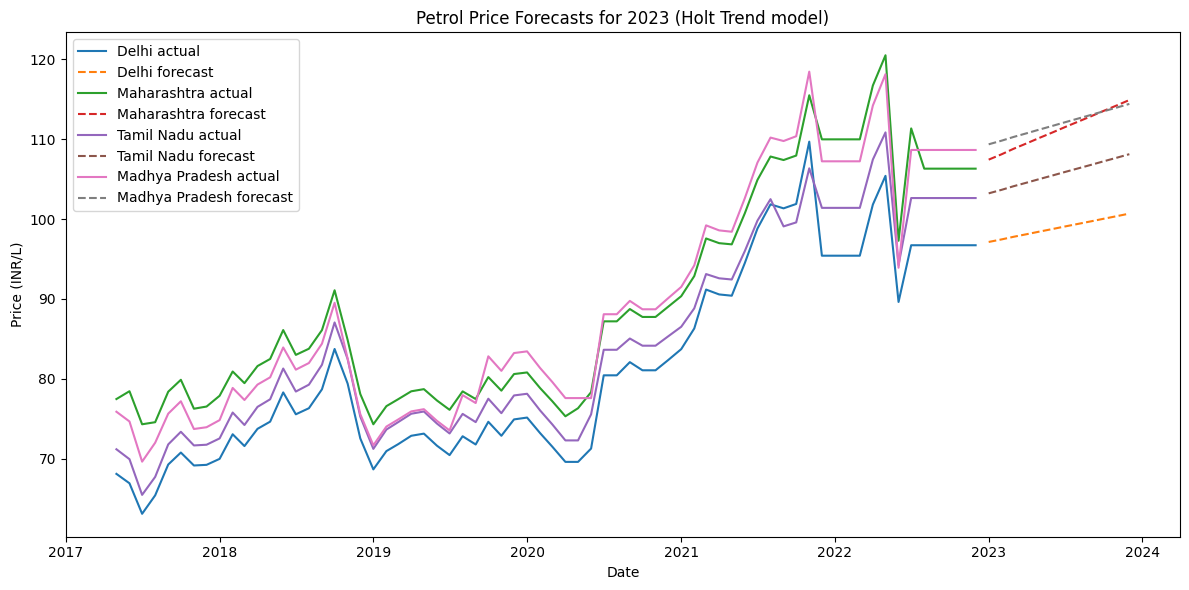

In [16]:
states_to_plot = ["Delhi", "Maharashtra", "Tamil Nadu", "Madhya Pradesh"]

plt.figure(figsize=(12,6))

for st in states_to_plot:
    plt.plot(wide[st], label=f"{st} actual")
    plt.plot(future_df[st], linestyle="dashed", label=f"{st} forecast")

plt.title("Petrol Price Forecasts for 2023 (Holt Trend model)")
plt.xlabel("Date")
plt.ylabel("Price (INR/L)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
states_to_plot = ["Delhi", "Maharashtra", "Tamil Nadu", "Madhya Pradesh"]

plt.figure(figsize=(12,6))

for st in states_to_plot:
    plt.plot(wide[st], label=f"{st} actual")
    plt.plot(future_df[st], linestyle="dashed", label=f"{st} forecast")

plt.title("Petrol Price Forecasts for 2023 (Holt Trend model)")
plt.xlabel("Date")
plt.ylabel("Price (INR/L)")
plt.legend()
plt.tight_layout()
plt.show()
